<a href="https://colab.research.google.com/github/gremlin97/EVA-8/blob/main/S10/s10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
!pip install einops
!pip install torchinfo
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
# Importing required libraries

import torch
from torch import nn
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import torch.nn.functional as F  
from torchinfo import summary   
from torchvision import datasets, transforms
import torchvision
import torch.optim as optim
import numpy as np

**Notes on Output Dimensions:**

```
hxwx3 => 224x224x3 => P=16

14x14x3 => 14x14x512

h=8

14x14x8x64

bx196xdim=512

1x196x512

1x14x14x512
```

In [66]:
class Embedding(nn.Module):
  def __init__(self,embedding_dim,num_patches,shape,in_channels=3,patch_size=16):
    super().__init__()
    self.patch = nn.Conv2d(in_channels,out_channels=embedding_dim,kernel_size=patch_size,stride=patch_size,padding=0) # b x dim x ph x pw == bx512x14x14
    #self.flatten = nn.Flatten(start_dim = 2, end_dim=-1) # bx512x196
    # self.cls_token = nn.Parameter(torch.randn(1,1,embedding_dim),requires_grad=True) # bx197x512 (Permuted: 0,2,1)
    self.pos_embedding = nn.Parameter(torch.randn(1,embedding_dim,shape,shape),requires_grad=True) # b x 197 x 512

  def forward(self,x):
    b,_,h,w = x.shape
    x = self.patch(x)
    #x = self.flatten(x)
    # x = x.permute(0,2,1)
    # b_cls_token = self.cls_token.expand(b,-1,-1)
    # x = torch.cat((b_cls_token,x),dim=1)
    x = x + self.pos_embedding
    # print(x.shape)
    # x = x.reshape([b,-1,h,w])
    return x

In [67]:
class MhSelfAttention(nn.Module):
  def __init__(self, in_channels, out_channels=512, head_channels=8):
    super().__init__()
    self.head_channels = head_channels
    self.heads = out_channels//head_channels
    self.scale = head_channels**-0.5

    self.k = nn.Conv2d(in_channels,out_channels,1)
    self.q = nn.Conv2d(in_channels,out_channels,1)
    self.v = nn.Conv2d(in_channels,out_channels,1)

    self.unify_heads = nn.Conv2d(out_channels,out_channels,1)

  def forward(self, x):

    b,_,h,w = x.shape
    keys = self.k(x).view(b,self.heads,self.head_channels,-1) # bx8x64x196
    queries = self.q(x).view(b,self.heads,self.head_channels,-1)
    values = self.v(x).view(b,self.heads,self.head_channels,-1) 

    # print("K",keys.shape)
    # print("Q",queries.shape)
    # print("V",values.shape)

    attend = queries @ keys.transpose(-2,-1)*self.scale
    attention = F.softmax(attend,dim=-2) # Softmax along the channels (0-1)

    out = attention @ values
    out = out.view(b,-1,h,w)
    out = self.unify_heads(out)

    return out

In [68]:

class FeedForward(nn.Module):
  def __init__(self,in_channels,out_channels,multf=4):
    super().__init__()
    hidden_channels = in_channels * multf
    self.net = nn.Sequential(
        nn.Conv2d(in_channels,hidden_channels,1),
        nn.GELU(),
        nn.Conv2d(hidden_channels,out_channels,1)
    )
    
  def forward(self,x):
    x = self.net(x)
    return x      

In [69]:
class PreNormChannels(nn.Module):
  def __init__(self,embedding_dim,fn):
    super().__init__()
    self.lnorm = nn.LayerNorm(embedding_dim)
    self.fn = fn
  
  def forward(self,x,**kwargs):
    x = x.transpose(1, -1)
    x = self.lnorm(x)
    x = self.fn(x.transpose(-1, 1),**kwargs)

    return x

In [70]:
class Transformer(nn.Module):
  def __init__(self,depth,head_c,in_c,out_c):
    super().__init__()

    self.layers = nn.ModuleList([])
    for _ in range(depth):
      self.layers.append(nn.ModuleList([
          PreNormChannels(out_c,MhSelfAttention(in_channels=in_c, out_channels=out_c,head_channels=head_c)),
          PreNormChannels(out_c,FeedForward(in_c,out_c,4))
      ]))

  def forward(self,x):
    for attn,ff in self.layers:
      x = attn(x) + x
      x = ff(x) + x
    
    return x

In [71]:
class ViT(nn.Module):
  def __init__(self,image_size,patch_size,in_channels,embedding_dim,depth,head_channels):
    super().__init__()
    reduced_size = image_size//patch_size

    image_height = image_size
    image_width = image_size

    num_patches = (image_height*image_width)//(patch_size*patch_size)

    self.embedding = Embedding(embedding_dim,num_patches,reduced_size,in_channels,patch_size)
    self.transformer = Transformer(depth,head_channels,embedding_dim,embedding_dim)
    self.norm =  nn.LayerNorm(embedding_dim)
    self.mlp_head = nn.Sequential(
          nn.GELU(),
          nn.AdaptiveAvgPool2d(1),
          nn.Flatten(),
          nn.Linear(embedding_dim, 10)
    )

  def forward(self,x):
    x = self.embedding(x)
    x = self.transformer(x)
    x = x.transpose(1,-1)
    x = self.norm(x)
    x = x.transpose(-1,1)
    # print(x.shape)
    x = self.mlp_head(x)
    return x

In [72]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [73]:
device

device(type='cuda')

In [74]:
model = ViT(32,2,3,32,4,8)
# image_size,patch_size,in_channels,embedding_dim,depth,head_channels
model.to(device)

ViT(
  (embedding): Embedding(
    (patch): Conv2d(3, 32, kernel_size=(2, 2), stride=(2, 2))
  )
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNormChannels(
          (lnorm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): MhSelfAttention(
            (k): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
            (q): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
            (v): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
            (unify_heads): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
          )
        )
        (1): PreNormChannels(
          (lnorm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
              (1): GELU(approximate='none')
              (2): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
            )
          )
        )
      )

In [75]:
out = model(torch.randn(1,3,32,32).to(device))
print(out)

tensor([[-0.2556, -0.0601, -0.0457,  0.1234,  0.0248, -0.2149,  0.1348, -0.0349,
         -0.1243,  0.0293]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [76]:
random_input_image = (1, 3, 32, 32)
summary(model,
        input_size=random_input_image, # try swapping this for "random_input_image_error" 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                               [1, 3, 32, 32]       [1, 10]              --                   True
├─Embedding (embedding)                                 [1, 3, 32, 32]       [1, 32, 16, 16]      8,192                True
│    └─Conv2d (patch)                                   [1, 3, 32, 32]       [1, 32, 16, 16]      416                  True
├─Transformer (transformer)                             [1, 32, 16, 16]      [1, 32, 16, 16]      --                   True
│    └─ModuleList (layers)                              --                   --                   --                   True
│    │    └─ModuleList (0)                              --                   --                   12,704               True
│    │    └─ModuleList (1)                              --                   --                   12,704               True
│  

In [77]:
IMAGE_SIZE = 32

NUM_CLASSES = 10
NUM_WORKERS = 8
BATCH_SIZE = 128
EPOCHS = 25

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-1

cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2471, 0.2435, 0.2616)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.75, 1.0), ratio=(1.0, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandAugment(num_ops=1, magnitude=8),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
    transforms.RandomErasing(p=0.25)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=4)


Files already downloaded and verified
Files already downloaded and verified


In [78]:
import time

clip_norm = True
lr_schedule = lambda t: np.interp([t], [0, EPOCHS*2//5, EPOCHS*4//5, EPOCHS], 
                                  [0, 0.01, 0.01/20.0, 0])[0]

model = nn.DataParallel(model, device_ids=[0]).cuda()
opt = optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()

for epoch in range(EPOCHS):
    start = time.time()
    train_loss, train_acc, n = 0, 0, 0
    for i, (X, y) in enumerate(trainloader):
        model.train()
        X, y = X.cuda(), y.cuda()

        lr = lr_schedule(epoch + (i + 1)/len(trainloader))
        opt.param_groups[0].update(lr=lr)

        opt.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(X)
            loss = criterion(output, y)

        scaler.scale(loss).backward()
        if clip_norm:
            scaler.unscale_(opt)
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(opt)
        scaler.update()
        
        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        n += y.size(0)
        
    model.eval()
    test_acc, m = 0, 0
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):
            X, y = X.cuda(), y.cuda()
            with torch.cuda.amp.autocast():
                output = model(X)
            test_acc += (output.max(1)[1] == y).sum().item()
            m += y.size(0)

    print(f'ViT: Epoch: {epoch} | Train Acc: {train_acc/n:.4f}, Test Acc: {test_acc/m:.4f}, Time: {time.time() - start:.1f}, lr: {lr:.6f}')


ViT: Epoch: 0 | Train Acc: 0.2049, Test Acc: 0.2904, Time: 78.6, lr: 0.001000
ViT: Epoch: 1 | Train Acc: 0.2459, Test Acc: 0.2719, Time: 72.1, lr: 0.002000
ViT: Epoch: 2 | Train Acc: 0.2628, Test Acc: 0.3221, Time: 68.4, lr: 0.003000
ViT: Epoch: 3 | Train Acc: 0.2956, Test Acc: 0.3350, Time: 68.1, lr: 0.004000
ViT: Epoch: 4 | Train Acc: 0.3384, Test Acc: 0.4035, Time: 70.2, lr: 0.005000
ViT: Epoch: 5 | Train Acc: 0.3870, Test Acc: 0.4614, Time: 68.7, lr: 0.006000
ViT: Epoch: 6 | Train Acc: 0.4248, Test Acc: 0.5008, Time: 69.1, lr: 0.007000
ViT: Epoch: 7 | Train Acc: 0.4421, Test Acc: 0.4991, Time: 70.3, lr: 0.008000
ViT: Epoch: 8 | Train Acc: 0.4646, Test Acc: 0.5187, Time: 68.8, lr: 0.009000
ViT: Epoch: 9 | Train Acc: 0.4723, Test Acc: 0.5259, Time: 68.0, lr: 0.010000
ViT: Epoch: 10 | Train Acc: 0.4879, Test Acc: 0.5434, Time: 66.4, lr: 0.009050
ViT: Epoch: 11 | Train Acc: 0.5014, Test Acc: 0.5681, Time: 66.5, lr: 0.008100
ViT: Epoch: 12 | Train Acc: 0.5158, Test Acc: 0.5588, Time: 64

In [79]:
model.module.transformer.layers[3][1].fn.net[0]

Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))

In [80]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision.transforms.functional as TF
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

def test_model(testloader,net):
  inc = []
  pre = []
  correct = 0
  total = 0
  test_loss = 0
  net.eval()
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images=images.to(device)
          labels=labels.to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          # Store wrongly predicted images
          if (predicted != labels).sum().item()>0:
            wrong_idx = ((predicted != labels).nonzero()[:,0])[0].item()
            wrong_samples = images[wrong_idx]
            wrong_preds = predicted[wrong_idx]
            actual_preds = labels.view_as(predicted)[wrong_idx]

            # Undo normalization
            wrong_samples = wrong_samples * 0.5
            wrong_samples = wrong_samples + 0.5
            wrong_samples = wrong_samples * 255.
            wrong_samples = wrong_samples.byte()
            img = TF.to_pil_image(wrong_samples)
            # print(img.shape)
            inc.append(img)
            pre.append(wrong_preds)

      plot_arr = []
      for i in range(len(inc)):
        # plot_arr.append(inc[i].cpu().data.numpy()[0])
        plot_arr.append(inc[i])

  print('Accuracy of the network on the 10000 test images: %d %%' % (
      100 * correct / total))
  
  return plot_arr, pre


def grad_cam(net, plot_arr):
  target_layers = [model.module.transformer.layers[3][1].fn.net[0]]
  res = []
  for i in range(0,10):
    input_tensor = preprocess_image(plot_arr[i],
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
    img = plot_arr[i]
    img = np.float32(img) / 255
    with GradCAM(model=net,
                target_layers=target_layers,
                use_cuda=torch.cuda.is_available()) as cam:
        grayscale_cam = cam(input_tensor=input_tensor,
                            targets=[ClassifierOutputTarget(i)])[0, :]
        cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)

    img_g = Image.fromarray(cam_image)
    res.append(img_g)
  return res

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [81]:
plot,pre = test_model(testloader,model)
res = grad_cam(model, plot)

Accuracy of the network on the 10000 test images: 65 %


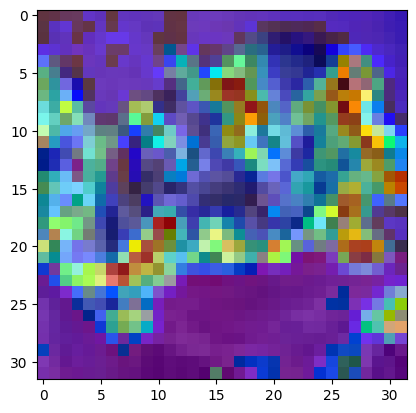

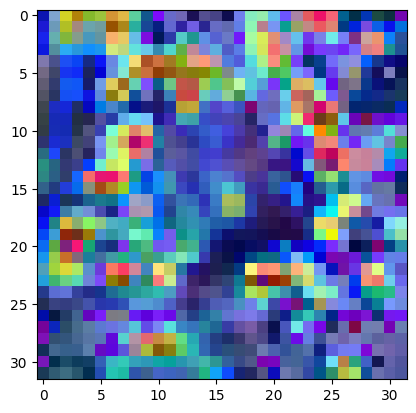

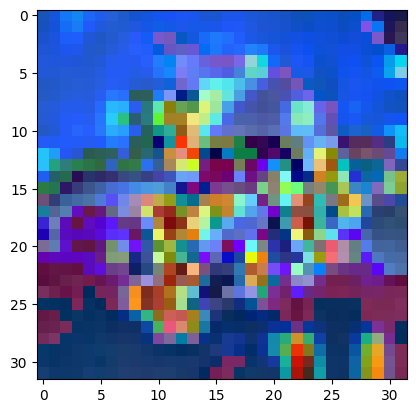

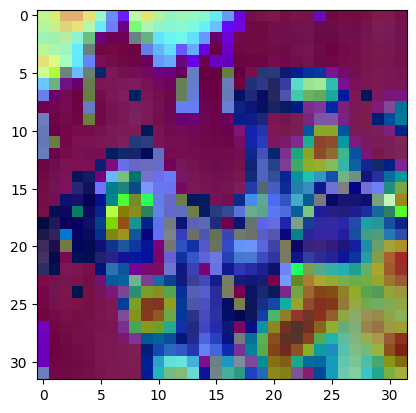

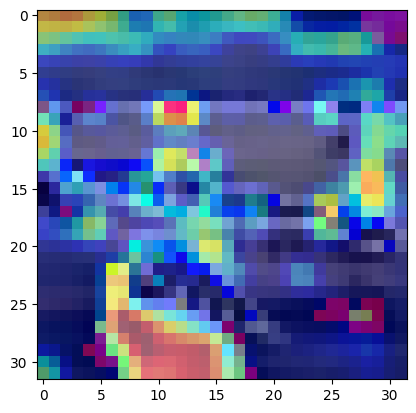

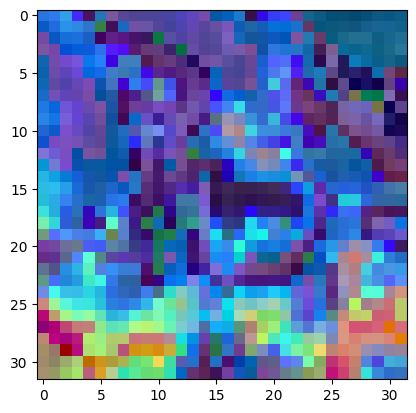

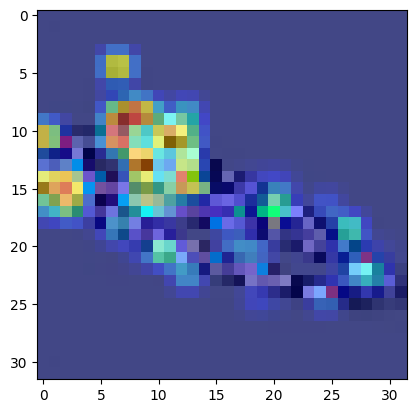

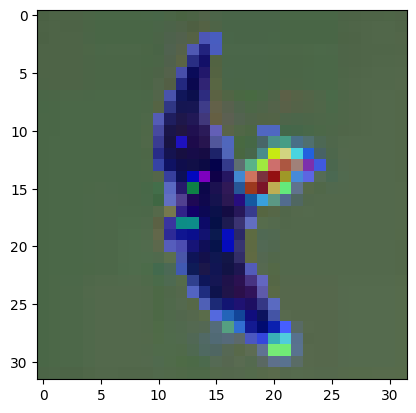

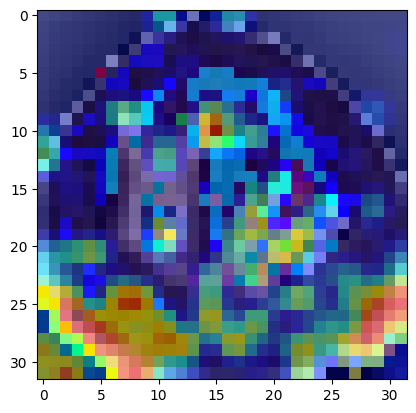

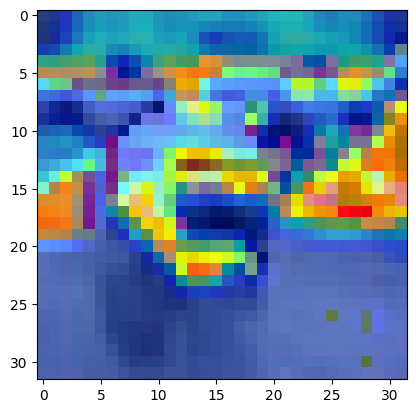

In [82]:
for x in res:
    plt.figure()
    plt.imshow(x)